In [2]:
import torch
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [3]:
import subprocess
from transformers import AutoModel, pipeline, Trainer, AutoTokenizer
import json
from datasets import Dataset, load_dataset, concatenate_datasets
import evaluate
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

c:\GitHub\PRPR\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

In [5]:
sampling_strategy = 1.0
rsmpl = RandomUnderSampler(sampling_strategy=sampling_strategy)

In [7]:

from tree_sitter import Language, Parser


CPP_LANGUAGE = Language('build/my-languages.so', 'cpp')

parser = Parser()
parser.set_language(CPP_LANGUAGE)

c:\GitHub\PRPR\.venv\lib\site-packages\tree_sitter\__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


In [6]:
def get_index_code_dict(emb_ds):
    res_dict = {}
    
    for el in emb_ds:
        res_dict[el["index"]] = el["embedding"]
        
    return res_dict
    

In [7]:
#эмбеддинги для батча
def get_embeddings(inputs, model):
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state.mean(dim=1)
    return embeddings

In [8]:
def get_pairs_ds(emb_ds):
    id = 0
    print(len(emb_ds))
    id_1 = []
    id_2 = []
    is_same = []
    same_class = []
    for i in range(len(emb_ds)-1):
        id += 1
        if id % 100 == 0 or id == 10:
            print(id)
        for j in range(i+1, len(emb_ds)):
            id_1.append(i)
            id_2.append(j)
            are_same = emb_ds[i]["label"] == emb_ds[j]["label"]
            is_same.append(int(are_same))
            if are_same:
                same_class.append(emb_ds[i]["label"])
            else:
                same_class.append(-100)

    dataset = Dataset.from_dict({ "id_1":id_1,"id_2": id_2,
                                    "is_same": is_same, "same_class": same_class})
    return dataset

In [9]:
        
def get_similarities_ds(emb_ds, resampled_ds):
    X = []
    y = []
    for el in resampled_ds:
        conc_tensor = torch.cat([
            torch.Tensor(emb_ds[el["id_1"]]["embeddings"]),
            torch.Tensor(emb_ds[el["id_2"]]["embeddings"]),
            torch.Tensor(pairwise_distances(emb_ds[el["id_1"]]["embeddings"],emb_ds[el["id_2"]]["embeddings"],
                                                   metric='cosine'))
        ], dim=1)
        X.append(conc_tensor.view(-1))
        y.append(el["is_same"])
    X_train, X_t, y_train, y_t = train_test_split(X, y, test_size=0.3, stratify=y, random_state=49)
    
    X_eval, X_test, y_eval, y_test = train_test_split(X_t, y_t, test_size=0.7, random_state=64)
    return X_train, X_eval, X_test, y_train, y_eval, y_test
        

In [10]:
def get_accuracy(emb_dataset):
    index_1 = []
    index_2 = []
    code_1 = []
    code_2 = []
    is_clones = []
    similarities = []
    for i in range(len(emb_dataset) - 1):
        i_label = emb_dataset[i]["label"]
        i_embeddings = torch.Tensor(emb_dataset[i]["embedding"][0]).reshape([1, -1])
        
        if i % 10 == 0:
            print(i)
            
        for j in range(i+1, len(emb_dataset)):
            j_label = emb_dataset[j]["label"]
            j_embeddings = torch.Tensor(emb_dataset[j]["embedding"][0]).reshape([1, -1])
            
            similarity = pairwise_distances(i_embeddings,j_embeddings,
                                                   metric='fgh')
            
            index_1.append(emb_dataset[i]["index"])
            index_2.append(emb_dataset[j]["index"])
            code_1.append(emb_dataset[i]["res_code"])
            code_2.append(emb_dataset[j]["res_code"])
            is_clones.append(int(emb_dataset[i]["label"] == emb_dataset[j]["label"]))
            similarities.append(similarity)
            
    acc_dataset = Dataset.from_dict({ "index_1":index_1,"index_2": index_2, "is_clones": is_clones,
                                "similarities": similarities})
    return acc_dataset
            
    
    

SEXP+CODE

In [13]:
def get_tokenized_dataset_sexp_code(datafile, model):
    index = []
    label = []
    code = []
    code_1 = []
    code_2 = []
    bin_labels = []

    input_ids_1 = []
    input_ids_2 = []
    att_mask_1 = []
    att_mask_2 = []
    embeddings = []


    cnt = 0
    with open(datafile) as file:
            for line in file.readlines():
                cnt += 1   
                if cnt%100==0:
                    print(cnt)
                
                json_line = json.loads(line)
                index.append(int(json_line["index"]))
                label.append(int(json_line["label"]) - 1)
                clear_code = json_line["code"].replace("\r", "").replace("\n","").replace("\t","")
                
                tree = parser.parse(bytes(clear_code, 'utf8'))
                sexp = str(tree.root_node.sexp())
                result = clear_code + sexp
                code.append(result)
                embeddings.append(get_embeddings(tokenizer(result, max_length = 512, truncation=True, pad_to_max_length=True,  return_tensors='pt'), model))
                

    dataset = Dataset.from_dict({ "res_code":code,"index": index, 
                                 "embeddings": embeddings,
                                "label": label})
    return dataset

In [14]:
rsm_test_sexp_code = get_tokenized_dataset_sexp_code("rsm_test.jsonl", model)
rsm_test_sexp_code.to_json("rsm_test_sexp_code.jsonl")

c:\GitHub\PRPR\.venv\lib\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


100
200
300
400
500
600
700
800
900
1000
1100
1200


Creating json from Arrow format: 100%|██████████| 2/2 [00:00<00:00,  9.34ba/s]


17971178

In [15]:
rsm_test_sexp_code = load_dataset("json", data_files="rsm_test_sexp_code.jsonl")["train"]

Generating train split: 1200 examples [00:00, 13724.67 examples/s]


In [16]:
rsm_test_sexp_code_pairs = get_pairs_ds(rsm_test_sexp_code)
rsm_test_sexp_code_pairs.to_json("rsm_test_sexp_code_pairs_1.jsonl")

1200
10
100
200
300
400
500
600
700
800
900
1000
1100


Creating json from Arrow format: 100%|██████████| 720/720 [00:00<00:00, 822.07ba/s]


38846610

In [12]:
rsm_test_sexp_code_pairs = load_dataset("json", data_files="rsm_test_sexp_code_pairs_1.jsonl")["train"]
rsm_test_sexp_code_pairs

Generating train split: 118800 examples [00:00, 1503765.77 examples/s]


Dataset({
    features: ['id_1', 'id_2', 'same_class', '__index_level_0__', 'is_same'],
    num_rows: 118800
})

In [11]:
rsm_test_sexp_code = load_dataset("json", data_files="rsm_test_sexp_code.jsonl")["train"]
rsm_test_sexp_code

Generating train split: 1200 examples [00:00, 6417.07 examples/s]


Dataset({
    features: ['res_code', 'index', 'embeddings', 'label'],
    num_rows: 1200
})

In [19]:
X = pd.DataFrame({"id_1": rsm_test_sexp_code_pairs["id_1"], "id_2": rsm_test_sexp_code_pairs["id_2"], "same_class": rsm_test_sexp_code_pairs["same_class"]})

y = rsm_test_sexp_code_pairs["is_same"]

X_resampled, y_resampled = rsmpl.fit_resample(X, y)

rsm_test_sexp_code_pairs = Dataset.from_pandas(X_resampled)

rsm_test_sexp_code_pairs = rsm_test_sexp_code_pairs.add_column("is_same", y_resampled)

rsm_test_sexp_code_pairs.to_json("rsm_test_sexp_code_pairs_1.jsonl")

Creating json from Arrow format: 100%|██████████| 119/119 [00:00<00:00, 687.86ba/s]


9516380

In [21]:
len(rsm_test_sexp_code_pairs.filter(lambda el: el["is_same"] == 1)) ==  len(rsm_test_sexp_code_pairs.filter(lambda el: el["is_same"] == 0))
print(len(rsm_test_sexp_code_pairs))
print(len(rsm_test_sexp_code_pairs.filter(lambda el: el["is_same"] == 1)))

Filter: 100%|██████████| 118800/118800 [00:00<00:00, 263397.66 examples/s]


118800


Filter: 100%|██████████| 118800/118800 [00:00<00:00, 263396.96 examples/s]

59400


In [13]:
X_train, X_eval, X_test, y_train, y_eval, y_test = get_similarities_ds(rsm_test_sexp_code, rsm_test_sexp_code_pairs)

In [14]:
from sklearn.metrics import f1_score

In [15]:
len(list(filter(lambda el: el == 0, y_train))) == len(list(filter(lambda el: el ==1, y_train)))

True

Epoch: 1 Validation Accuracy: 0.7806771417882529
Epoch: 2 Validation Accuracy: 0.8235129068462402
Epoch: 3 Validation Accuracy: 0.8538159371492705
Epoch: 4 Validation Accuracy: 0.8543771043771043
Epoch: 5 Validation Accuracy: 0.8571829405162739
Epoch: 6 Validation Accuracy: 0.8653198653198653
Epoch: 7 Validation Accuracy: 0.7535540591096147
Epoch: 8 Validation Accuracy: 0.8888888888888888
Epoch: 9 Validation Accuracy: 0.8769173213617658
Epoch: 10 Validation Accuracy: 0.8894500561167228
Epoch: 11 Validation Accuracy: 0.8923494201271979
Epoch: 12 Validation Accuracy: 0.8734567901234568
Epoch: 13 Validation Accuracy: 0.7307332585110363
Early stopping triggered at epoch 13


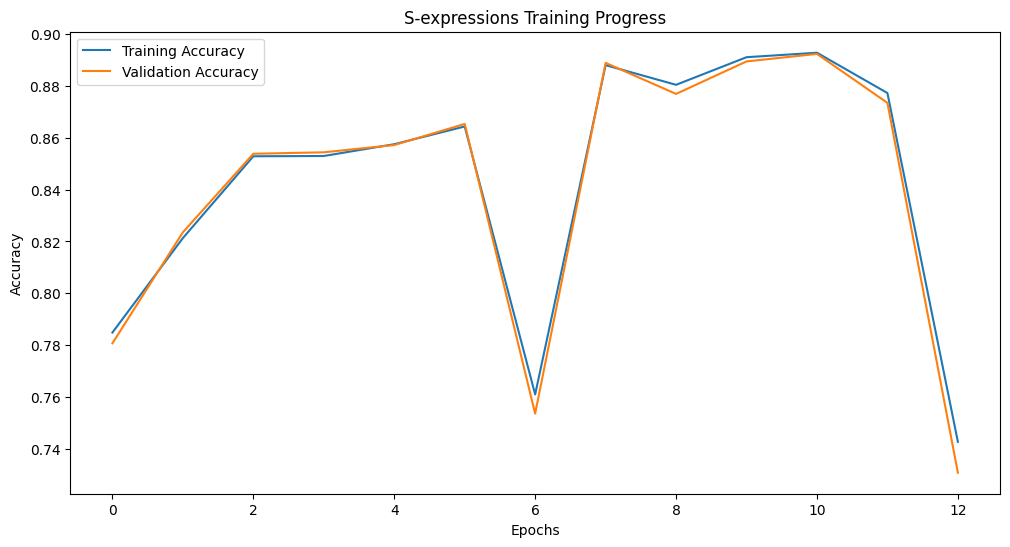

Accuracy: 0.7374939874939875
f1_score: 0.6505522650872418
S-выражения


Creating json from Arrow format: 100%|██████████| 25/25 [00:00<00:00, 581.45ba/s]


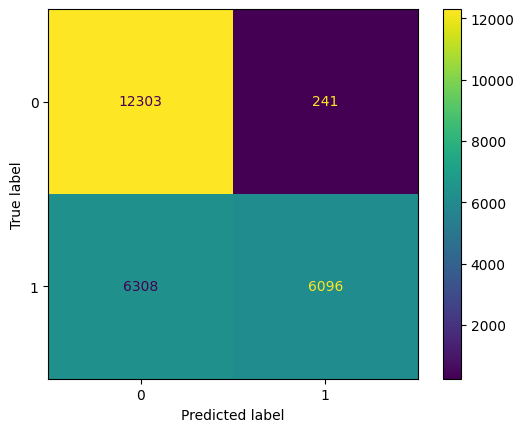

In [17]:
#классификационная голова с логированием

perceptron = Perceptron(tol=None, max_iter=1)

best_accuracy = 0
tol = 0.01
no_improvement = 0
max_no_improvement = 5

train_acc = []
val_acc = []

for epoch in range(1000):
    perceptron.partial_fit(X_train, y_train, classes=np.unique(y_train))
    
    y_pred_eval = perceptron.predict(X_eval)
    accuracy_eval = accuracy_score(y_eval, y_pred_eval)
    
    y_pred_train = perceptron.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    
    if accuracy_eval > best_accuracy + tol:
        best_accuracy = accuracy_eval
        no_improvement = 0
    else:
        no_improvement += 1
        
    train_acc.append(accuracy_train)
    val_acc.append(accuracy_eval)
    
    print('Epoch:', epoch+1, 'Validation Accuracy:', accuracy_eval)
    
    if no_improvement >= max_no_improvement:
        print('Early stopping triggered at epoch', epoch+1)
        break
    
    
title = "S-выражения"
    
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('S-expressions Training Progress')
plt.legend()
plt.savefig('acc_график'+title+'prj.jpg')
plt.show()
    


y_pred = perceptron.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_display = ConfusionMatrixDisplay(cm).plot()

print(title)
Dataset.from_dict({"orig":y_test, "prediction": y_pred}).to_json("s-выражения_prediction.json")
plt.savefig('confusion_matrix_'+title+'prj.jpg')

Accuracy: 0.8095638928972262
f1_score: 0.7866540931339531
SEXP_CODE_EStop


Creating json from Arrow format: 100%|██████████| 25/25 [00:00<00:00, 694.47ba/s]


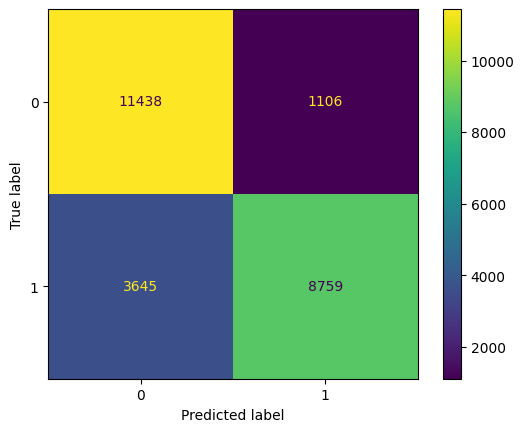

In [16]:
perceptron = Perceptron(early_stopping=True, tol=5, max_iter=1000)
perceptron.fit(X_train, y_train)

y_pred = perceptron.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_display = ConfusionMatrixDisplay(cm).plot()
title = "SEXP_CODE_EStop"
print(title)
Dataset.from_dict({"orig":y_test, "prediction": y_pred}).to_json("exp_sexp_code_EStop_predicitons.json")
plt.savefig('confusion_matrix_'+title+'_1.jpg')

In [22]:
print(classification_report(y_test, y_pred, target_names=["не являются клонами", "являются клонами"]))

                     precision    recall  f1-score   support

не являются клонами       0.66      0.98      0.79     12544
   являются клонами       0.96      0.49      0.65     12404

           accuracy                           0.74     24948
          macro avg       0.81      0.74      0.72     24948
       weighted avg       0.81      0.74      0.72     24948



In [23]:
def get_table(ch_1, ch_2):
    a = 0
    b = 0
    c = 0
    d = 0
    for i in range(len(ch_1)):
        if ch_1[i] == 1 and ch_2[i] == 1:
            a += 1
        elif ch_1[i] == 1 and ch_2[i] == 0:
            b += 1
        elif ch_1[i] == 0 and ch_2[i] == 1:
            c += 1
        elif ch_1[i] == 0 and ch_2[i] == 0:
            d += 1
            
    return [[a,b],[c,d]]
    

In [24]:
from statsmodels.stats.contingency_tables import mcnemar 

def tt(ch_1, ch_2):
	result = mcnemar(get_table(ch_1, ch_2), exact=True)
	print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
	alpha = 0.05
	if result.pvalue > alpha:
		print('H0 не отвергнута, аугментация не эффективна')
	else:
		print('H0 отвергнута, аугментация эффективна')
	print(f"p-value: {result.pvalue}")

In [26]:
simple_code = load_dataset("json", data_files="..\простой_код\простой_код_prediction.json")["train"]
print(simple_code)
simple_code_result = []
for el in simple_code:
    if el["prediction"] == el["orig"]:
        simple_code_result.append(1)
    else:
        simple_code_result.append(0)
print(simple_code_result)

Generating train split: 24948 examples [00:00, 959326.49 examples/s]


Dataset({
    features: ['orig', 'prediction'],
    num_rows: 24948
})
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1

In [27]:
sexp_code = load_dataset("json", data_files="s-выражения_prediction.json")["train"]
print(sexp_code)
sexp_code_result = []
for el in sexp_code:
    if el["prediction"] == el["orig"]:
        sexp_code_result.append(1)
    else:
        sexp_code_result.append(0)
print(sexp_code_result)

Generating train split: 24948 examples [00:00, 1247193.04 examples/s]


Dataset({
    features: ['orig', 'prediction'],
    num_rows: 24948
})
[1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1

In [28]:
print(tt(simple_code_result, sexp_code_result))

statistic=788.000, p-value=0.000
H0 отвергнута, аугментация эффективна
p-value: 0.0
None
